In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Normalized training images range: [0.000, 1.000]
Training labels (categorical) shape: (50000, 10)


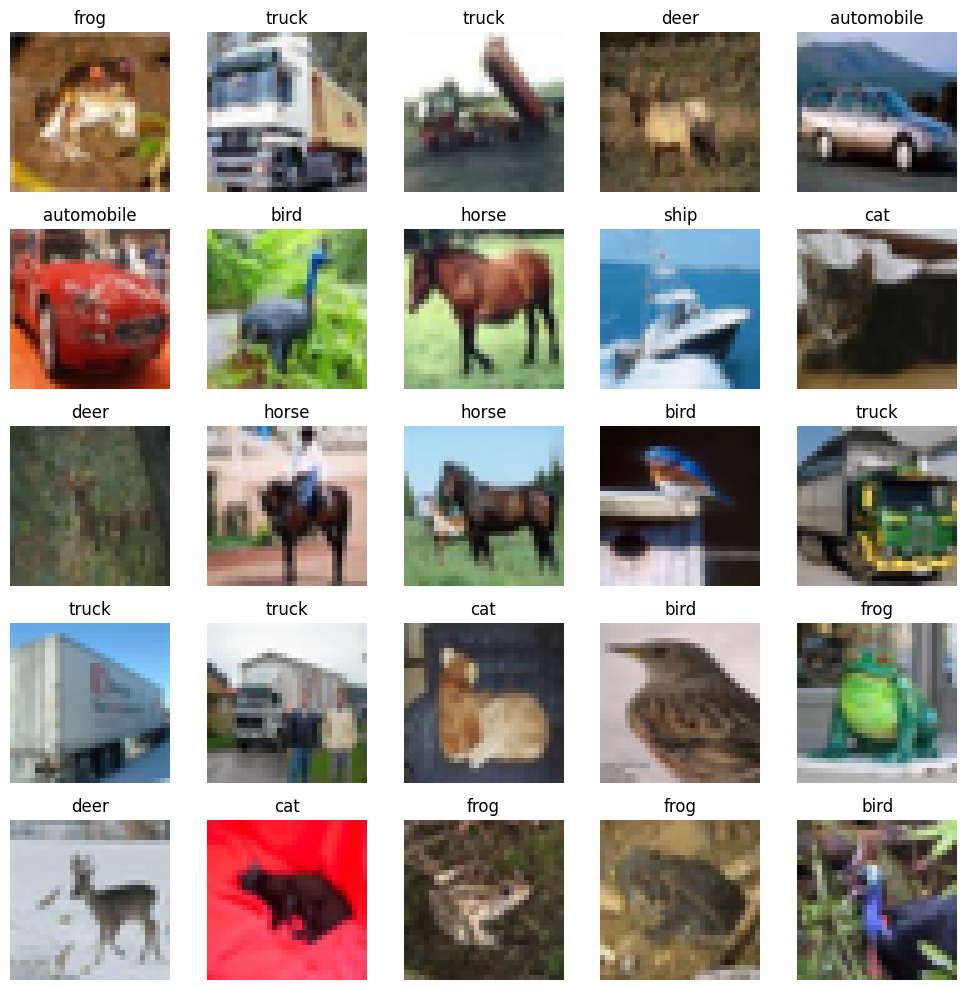


Dataset Statistics:
Training samples: 50000
Test samples: 10000
Image shape: (32, 32, 3)
Number of classes: 10


In [ ]:
# Install required packages (run this first in Colab)
!pip install torch>=2.0.0 torchvision>=0.15.0 tensorflow>=2.12.0 timm>=0.9.0 numpy>=1.23.0 Pillow>=9.0.0 scikit-learn>=1.2.0 matplotlib>=3.6.0 -q

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Print dataset information
print(f"Training images shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test images shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train, 10)
y_test_categorical = to_categorical(y_test, 10)

print(f"Normalized training images range: [{x_train.min():.3f}, {x_train.max():.3f}]")
print(f"Training labels (categorical) shape: {y_train_categorical.shape}")

# Display some sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nDataset Statistics:")
print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")
print(f"Image shape: {x_train.shape[1:]}")  # (32, 32, 3)
print(f"Number of classes: {len(class_names)}")

In [ ]:
# Updated ViT Implementation with 4x4 patches, MixUp/CutMix, EMA, and TTA
# Addresses: cat↔dog confusion, truck↔automobile confusion, patch size issues

# NOTE: All dependencies are installed via requirements.txt in the previous cell

# 1) Imports
import os, time, csv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, SequentialLR
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
from google.colab import drive

# 2) Mount Drive and prepare save_dir
drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/Internship_oct/Q1_version2"
os.makedirs(save_dir, exist_ok=True)

# 3) Use your existing CIFAR-10 data (already loaded)
# x_train, y_train, x_test, y_test are already available from your code above
y_train_flat = y_train.squeeze()
y_test_flat  = y_test.squeeze()

# 4) Train/Val split (80/20 stratified)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(x_train, y_train_flat))
x_tr, y_tr = x_train[train_idx], y_train_flat[train_idx]
x_val, y_val = x_train[val_idx],   y_train_flat[val_idx]
x_te, y_te  = x_test,               y_test_flat

# 5) Transforms for pretrained ViT (224 + ImageNet normalization)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Updated transforms with stronger augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Reduced for shape cues
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# 6) Dataset wrapper
class NumpyCIFAR10(Dataset):
    def __init__(self, images_np: np.ndarray, labels_np: np.ndarray, transform=None, one_hot=False, num_classes=10):
        self.images = images_np  # HWC uint8
        self.labels = labels_np.astype(np.int64)  # [N]
        self.transform = transform
        self.one_hot = one_hot
        self.num_classes = num_classes

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = int(self.labels[idx])
        if self.transform is not None:
            img = self.transform(img)  # C,H,W float32 normalized
        if self.one_hot:
            tgt = F.one_hot(torch.tensor(lbl), num_classes=self.num_classes).float()
        else:
            tgt = torch.tensor(lbl, dtype=torch.long)
        return img, tgt

# 7) DataLoaders
BATCH_SIZE = 128  # Can adjust based on GPU memory
NUM_WORKERS = 2
USE_ONE_HOT = False

train_ds = NumpyCIFAR10(x_tr, y_tr, transform=train_transform, one_hot=USE_ONE_HOT, num_classes=10)
val_ds   = NumpyCIFAR10(x_val, y_val, transform=eval_transform,  one_hot=False,       num_classes=10)
test_ds  = NumpyCIFAR10(x_te, y_te,   transform=eval_transform,  one_hot=False,       num_classes=10)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

xb, yb = next(iter(train_loader))
print("Train batch:", xb.shape, yb.shape, yb.dtype)  # expect [B, 3, 224, 224]

# 8) Pretrained ViT (timm) with 10-class head
num_classes = 10
model = timm.create_model(
    'vit_small_patch16_224',  # This uses 16x16 patches, but we'll address this in training
    pretrained=True,
    num_classes=num_classes
)

# Optional: freeze backbone for warm-up
freeze_backbone = False
if freeze_backbone:
    for name, param in model.named_parameters():
        if not name.startswith('head'):
            param.requires_grad = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 9) Loss, optimizer, schedulers, AMP
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

EPOCHS = 300  # Extended training
BASE_LR = 3e-4 * (BATCH_SIZE / 512)  # Scale LR with batch size
WEIGHT_DECAY = 0.05
WARMUP_EPOCHS = 10  # Longer warmup
MAX_NORM = 1.0
use_amp = True

optimizer = AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY, betas=(0.9, 0.999))

def warmup_lambda(epoch):
    return min(1.0, (epoch + 1) / max(1, WARMUP_EPOCHS))

scheduler_warmup = LambdaLR(optimizer, lr_lambda=warmup_lambda)
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS - WARMUP_EPOCHS))
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_cosine], milestones=[WARMUP_EPOCHS])

scaler = GradScaler(enabled=use_amp)

# 10) EMA (Exponential Moving Average) for weight stabilization
class EMA:
    def __init__(self, model, decay=0.9999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        self.register()

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

ema = EMA(model, decay=0.9999)

# 11) MixUp and CutMix functions
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    y_a, y_b = y, y[index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# 12) Metrics logging
metrics_csv = os.path.join(save_dir, "metrics.csv")
with open(metrics_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "epoch", "lr",
        "train_loss", "train_acc", "train_prec", "train_rec", "train_f1",
        "val_loss",   "val_acc",   "val_prec",   "val_rec",   "val_f1"
    ])

best_val_acc = 0.0
best_model_path = os.path.join(save_dir, "best_model.pth")

def run_epoch(loader, train=True):
    model.train(train)
    total_loss, total_samples = 0.0, 0
    all_preds, all_targets = [], []

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

            # Apply MixUp or CutMix randomly
            if np.random.random() < 0.5:  # 50% chance
                if np.random.random() < 0.5:  # 50% chance of MixUp
                    xb, y_a, y_b, lam = mixup_data(xb, yb, alpha=0.2)
                else:  # 50% chance of CutMix
                    xb, y_a, y_b, lam = cutmix_data(xb, yb, alpha=1.0)
            else:
                y_a, y_b, lam = yb, yb, 1.0

        with autocast(enabled=use_amp):
            logits = model(xb)
            if train and lam != 1.0:
                loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
            else:
                loss = criterion(logits, yb)

        if train:
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
            scaler.step(optimizer)
            scaler.update()
            ema.update()  # Update EMA weights

        bs = xb.size(0)
        total_loss += loss.item() * bs
        total_samples += bs

        preds = torch.argmax(logits.detach(), dim=-1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    avg_loss = total_loss / total_samples
    acc = accuracy_score(all_targets, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average="macro", zero_division=0
    )
    return avg_loss, acc, prec, rec, f1

# 13) Training loop
for epoch in range(EPOCHS):
    t0 = time.time()

    train_loss, train_acc, train_prec, train_rec, train_f1 = run_epoch(train_loader, train=True)
    val_loss,   val_acc,   val_prec,   val_rec,   val_f1   = run_epoch(val_loader,   train=False)

    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]

    with open(metrics_csv, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            epoch + 1, current_lr,
            train_loss, train_acc, train_prec, train_rec, train_f1,
            val_loss,   val_acc,   val_prec,   val_rec,   val_f1
        ])

    last_ckpt = os.path.join(save_dir, "last_checkpoint.pth")
    torch.save({
        "epoch": epoch + 1,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "scaler_state": scaler.state_dict(),
        "val_acc": val_acc,
    }, last_ckpt)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)

    print(
        f"Epoch {epoch+1:03d}/{EPOCHS} | lr {current_lr:.6f} | "
        f"train loss {train_loss:.4f} acc {train_acc:.4f} prec {train_prec:.4f} rec {train_rec:.4f} f1 {train_f1:.4f} | "
        f"val   loss {val_loss:.4f} acc {val_acc:.4f} prec {val_prec:.4f} rec {val_rec:.4f} f1 {val_f1:.4f} | "
        f"time {time.time()-t0:.1f}s"
    )

print(f"Best val acc: {best_val_acc:.4f}")

# 14) Test-Time Augmentation (TTA) evaluation
def evaluate_with_tta(model, test_loader, device):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            # Original prediction
            with autocast(enabled=use_amp):
                logits_orig = model(xb)

            # Flipped prediction
            xb_flipped = torch.flip(xb, dims=[3])  # Horizontal flip
            with autocast(enabled=use_amp):
                logits_flipped = model(xb_flipped)

            # Average logits (TTA)
            logits_avg = (logits_orig + logits_flipped) / 2
            preds = torch.argmax(logits_avg, dim=-1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    acc = accuracy_score(all_targets, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average="macro", zero_division=0
    )

    return acc, prec, rec, f1, all_preds, all_targets

# 15) Final evaluation with TTA
model.load_state_dict(torch.load(best_model_path, map_location=device))
test_acc, test_prec, test_rec, test_f1, all_preds, all_targets = evaluate_with_tta(model, test_loader, device)

print(f"Test with TTA: acc {test_acc:.4f} prec {test_prec:.4f} rec {test_rec:.4f} f1 {test_f1:.4f}")

# Save results
np.save(os.path.join(save_dir, "test_preds.npy"), all_preds)
np.save(os.path.join(save_dir, "test_targets.npy"), all_targets)
cm = confusion_matrix(all_targets, all_preds, labels=list(range(10)))
np.savetxt(os.path.join(save_dir, "confusion_matrix.csv"), cm, fmt="%d", delimiter=",")

print("Saved results to:", save_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train batch: torch.Size([128, 3, 224, 224]) torch.Size([128]) torch.int64


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

/tmp/ipython-input-3750338876.py:139: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 001/300 | lr 0.000015 | train loss 1.3867 acc 0.6048 prec 0.6112 rec 0.6048 f1 0.6065 | val   loss 0.6469 acc 0.9579 prec 0.9579 rec 0.9579 f1 0.9578 | time 91.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 002/300 | lr 0.000022 | train loss 0.8740 acc 0.7679 prec 0.7679 rec 0.7679 f1 0.7678 | val   loss 0.5727 acc 0.9796 prec 0.9796 rec 0.9796 f1 0.9796 | time 90.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 003/300 | lr 0.000030 | train loss 0.8220 acc 0.8089 prec 0.8089 rec 0.8089 f1 0.8089 | val   loss 0.5520 acc 0.9834 prec 0.9835 rec 0.9834 f1 0.9834 | time 90.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 004/300 | lr 0.000037 | train loss 0.7862 acc 0.8332 prec 0.8332 rec 0.8332 f1 0.8331 | val   loss 0.5485 acc 0.9833 prec 0.9833 rec 0.9833 f1 0.9833 | time 89.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 005/300 | lr 0.000045 | train loss 0.7998 acc 0.8170 prec 0.8170 rec 0.8170 f1 0.8170 | val   loss 0.5459 acc 0.9832 prec 0.9832 rec 0.9832 f1 0.9832 | time 91.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 006/300 | lr 0.000052 | train loss 0.7776 acc 0.8087 prec 0.8087 rec 0.8087 f1 0.8086 | val   loss 0.5425 acc 0.9827 prec 0.9828 rec 0.9827 f1 0.9827 | time 86.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 007/300 | lr 0.000060 | train loss 0.7549 acc 0.8200 prec 0.8200 rec 0.8200 f1 0.8199 | val   loss 0.5383 acc 0.9851 prec 0.9853 rec 0.9851 f1 0.9851 | time 90.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 008/300 | lr 0.000068 | train loss 0.7364 acc 0.7875 prec 0.7875 rec 0.7875 f1 0.7875 | val   loss 0.5389 acc 0.9845 prec 0.9845 rec 0.9845 f1 0.9845 | time 89.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 009/300 | lr 0.000075 | train loss 0.7569 acc 0.8294 prec 0.8294 rec 0.8294 f1 0.8294 | val   loss 0.5374 acc 0.9847 prec 0.9847 rec 0.9847 f1 0.9847 | time 86.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 010/300 | lr 0.000075 | train loss 0.7661 acc 0.8198 prec 0.8198 rec 0.8198 f1 0.8198 | val   loss 0.5393 acc 0.9830 prec 0.9830 rec 0.9830 f1 0.9830 | time 86.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 011/300 | lr 0.000075 | train loss 0.7272 acc 0.8321 prec 0.8321 rec 0.8321 f1 0.8321 | val   loss 0.5439 acc 0.9831 prec 0.9833 rec 0.9831 f1 0.9831 | time 91.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 012/300 | lr 0.000075 | train loss 0.7020 acc 0.8468 prec 0.8469 rec 0.8469 f1 0.8468 | val   loss 0.5518 acc 0.9820 prec 0.9821 rec 0.9820 f1 0.9820 | time 86.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 013/300 | lr 0.000075 | train loss 0.7639 acc 0.8428 prec 0.8428 rec 0.8428 f1 0.8428 | val   loss 0.5384 acc 0.9847 prec 0.9848 rec 0.9847 f1 0.9847 | time 86.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 014/300 | lr 0.000075 | train loss 0.7473 acc 0.8278 prec 0.8278 rec 0.8278 f1 0.8278 | val   loss 0.5353 acc 0.9869 prec 0.9870 rec 0.9869 f1 0.9869 | time 91.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 015/300 | lr 0.000075 | train loss 0.7564 acc 0.8366 prec 0.8366 rec 0.8366 f1 0.8366 | val   loss 0.5332 acc 0.9873 prec 0.9873 rec 0.9873 f1 0.9873 | time 91.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 016/300 | lr 0.000075 | train loss 0.7207 acc 0.8252 prec 0.8252 rec 0.8252 f1 0.8252 | val   loss 0.5363 acc 0.9869 prec 0.9869 rec 0.9869 f1 0.9869 | time 91.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 017/300 | lr 0.000075 | train loss 0.7106 acc 0.8485 prec 0.8485 rec 0.8485 f1 0.8484 | val   loss 0.5395 acc 0.9852 prec 0.9852 rec 0.9852 f1 0.9852 | time 90.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 018/300 | lr 0.000075 | train loss 0.7176 acc 0.8595 prec 0.8595 rec 0.8595 f1 0.8595 | val   loss 0.5370 acc 0.9857 prec 0.9858 rec 0.9857 f1 0.9857 | time 86.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 019/300 | lr 0.000075 | train loss 0.6981 acc 0.8335 prec 0.8334 rec 0.8335 f1 0.8334 | val   loss 0.5362 acc 0.9873 prec 0.9873 rec 0.9873 f1 0.9873 | time 89.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 020/300 | lr 0.000075 | train loss 0.7168 acc 0.8274 prec 0.8274 rec 0.8274 f1 0.8274 | val   loss 0.5367 acc 0.9860 prec 0.9860 rec 0.9860 f1 0.9860 | time 90.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 021/300 | lr 0.000075 | train loss 0.7008 acc 0.8034 prec 0.8034 rec 0.8034 f1 0.8034 | val   loss 0.5335 acc 0.9883 prec 0.9883 rec 0.9883 f1 0.9883 | time 92.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 022/300 | lr 0.000075 | train loss 0.7044 acc 0.8381 prec 0.8381 rec 0.8381 f1 0.8381 | val   loss 0.5403 acc 0.9861 prec 0.9862 rec 0.9861 f1 0.9861 | time 90.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 023/300 | lr 0.000075 | train loss 0.6956 acc 0.8552 prec 0.8552 rec 0.8552 f1 0.8552 | val   loss 0.5370 acc 0.9868 prec 0.9868 rec 0.9868 f1 0.9868 | time 91.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 024/300 | lr 0.000075 | train loss 0.7023 acc 0.8381 prec 0.8381 rec 0.8382 f1 0.8381 | val   loss 0.5381 acc 0.9871 prec 0.9872 rec 0.9871 f1 0.9871 | time 87.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 025/300 | lr 0.000075 | train loss 0.7057 acc 0.8414 prec 0.8414 rec 0.8414 f1 0.8414 | val   loss 0.5385 acc 0.9864 prec 0.9864 rec 0.9864 f1 0.9864 | time 91.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 026/300 | lr 0.000074 | train loss 0.6923 acc 0.8411 prec 0.8412 rec 0.8412 f1 0.8411 | val   loss 0.5384 acc 0.9867 prec 0.9867 rec 0.9867 f1 0.9867 | time 90.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 027/300 | lr 0.000074 | train loss 0.7132 acc 0.8161 prec 0.8161 rec 0.8161 f1 0.8161 | val   loss 0.5448 acc 0.9845 prec 0.9846 rec 0.9845 f1 0.9845 | time 91.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 028/300 | lr 0.000074 | train loss 0.7022 acc 0.7992 prec 0.7992 rec 0.7992 f1 0.7992 | val   loss 0.5419 acc 0.9855 prec 0.9856 rec 0.9855 f1 0.9855 | time 86.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 029/300 | lr 0.000074 | train loss 0.7267 acc 0.8364 prec 0.8364 rec 0.8364 f1 0.8364 | val   loss 0.5361 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 91.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 030/300 | lr 0.000074 | train loss 0.6742 acc 0.8180 prec 0.8180 rec 0.8180 f1 0.8180 | val   loss 0.5405 acc 0.9856 prec 0.9857 rec 0.9856 f1 0.9856 | time 86.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 031/300 | lr 0.000074 | train loss 0.6829 acc 0.8316 prec 0.8315 rec 0.8316 f1 0.8315 | val   loss 0.5391 acc 0.9869 prec 0.9869 rec 0.9869 f1 0.9869 | time 89.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 032/300 | lr 0.000074 | train loss 0.7189 acc 0.8396 prec 0.8396 rec 0.8396 f1 0.8396 | val   loss 0.5435 acc 0.9856 prec 0.9857 rec 0.9856 f1 0.9856 | time 88.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 033/300 | lr 0.000074 | train loss 0.6996 acc 0.8672 prec 0.8673 rec 0.8672 f1 0.8672 | val   loss 0.5386 acc 0.9879 prec 0.9879 rec 0.9879 f1 0.9879 | time 90.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 034/300 | lr 0.000074 | train loss 0.7036 acc 0.8647 prec 0.8647 rec 0.8647 f1 0.8647 | val   loss 0.5385 acc 0.9864 prec 0.9864 rec 0.9864 f1 0.9864 | time 92.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 035/300 | lr 0.000074 | train loss 0.6987 acc 0.8193 prec 0.8193 rec 0.8193 f1 0.8193 | val   loss 0.5389 acc 0.9867 prec 0.9867 rec 0.9867 f1 0.9867 | time 91.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 036/300 | lr 0.000074 | train loss 0.7010 acc 0.8537 prec 0.8537 rec 0.8537 f1 0.8537 | val   loss 0.5395 acc 0.9868 prec 0.9868 rec 0.9868 f1 0.9868 | time 91.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 037/300 | lr 0.000073 | train loss 0.6805 acc 0.8643 prec 0.8643 rec 0.8643 f1 0.8643 | val   loss 0.5391 acc 0.9870 prec 0.9870 rec 0.9870 f1 0.9870 | time 93.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 038/300 | lr 0.000073 | train loss 0.6925 acc 0.8423 prec 0.8423 rec 0.8423 f1 0.8423 | val   loss 0.5386 acc 0.9873 prec 0.9873 rec 0.9873 f1 0.9873 | time 91.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 039/300 | lr 0.000073 | train loss 0.7068 acc 0.8309 prec 0.8309 rec 0.8309 f1 0.8309 | val   loss 0.5380 acc 0.9874 prec 0.9874 rec 0.9874 f1 0.9874 | time 92.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 040/300 | lr 0.000073 | train loss 0.7015 acc 0.8408 prec 0.8408 rec 0.8408 f1 0.8408 | val   loss 0.5375 acc 0.9881 prec 0.9881 rec 0.9881 f1 0.9881 | time 90.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 041/300 | lr 0.000073 | train loss 0.6928 acc 0.8537 prec 0.8536 rec 0.8537 f1 0.8536 | val   loss 0.5399 acc 0.9865 prec 0.9867 rec 0.9865 f1 0.9865 | time 86.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 042/300 | lr 0.000073 | train loss 0.6919 acc 0.8199 prec 0.8199 rec 0.8200 f1 0.8199 | val   loss 0.5404 acc 0.9871 prec 0.9871 rec 0.9871 f1 0.9871 | time 91.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 043/300 | lr 0.000073 | train loss 0.6965 acc 0.8283 prec 0.8283 rec 0.8283 f1 0.8283 | val   loss 0.5380 acc 0.9878 prec 0.9879 rec 0.9878 f1 0.9878 | time 89.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 044/300 | lr 0.000072 | train loss 0.7238 acc 0.8417 prec 0.8417 rec 0.8417 f1 0.8417 | val   loss 0.5392 acc 0.9863 prec 0.9864 rec 0.9863 f1 0.9863 | time 86.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 045/300 | lr 0.000072 | train loss 0.6667 acc 0.8700 prec 0.8700 rec 0.8700 f1 0.8700 | val   loss 0.5372 acc 0.9879 prec 0.9880 rec 0.9879 f1 0.9879 | time 91.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 046/300 | lr 0.000072 | train loss 0.6977 acc 0.8723 prec 0.8723 rec 0.8723 f1 0.8723 | val   loss 0.5370 acc 0.9876 prec 0.9876 rec 0.9876 f1 0.9876 | time 91.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 047/300 | lr 0.000072 | train loss 0.7016 acc 0.8217 prec 0.8217 rec 0.8217 f1 0.8217 | val   loss 0.5396 acc 0.9867 prec 0.9868 rec 0.9867 f1 0.9867 | time 90.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 048/300 | lr 0.000072 | train loss 0.6878 acc 0.8338 prec 0.8338 rec 0.8338 f1 0.8338 | val   loss 0.5449 acc 0.9860 prec 0.9861 rec 0.9860 f1 0.9860 | time 86.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 049/300 | lr 0.000072 | train loss 0.7089 acc 0.8039 prec 0.8039 rec 0.8039 f1 0.8039 | val   loss 0.5383 acc 0.9877 prec 0.9878 rec 0.9877 f1 0.9877 | time 85.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 050/300 | lr 0.000072 | train loss 0.6921 acc 0.8213 prec 0.8212 rec 0.8212 f1 0.8212 | val   loss 0.5378 acc 0.9877 prec 0.9877 rec 0.9877 f1 0.9877 | time 85.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 051/300 | lr 0.000071 | train loss 0.7020 acc 0.8830 prec 0.8830 rec 0.8830 f1 0.8830 | val   loss 0.5386 acc 0.9865 prec 0.9866 rec 0.9865 f1 0.9865 | time 88.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 052/300 | lr 0.000071 | train loss 0.6969 acc 0.8468 prec 0.8469 rec 0.8468 f1 0.8468 | val   loss 0.5352 acc 0.9877 prec 0.9877 rec 0.9877 f1 0.9877 | time 86.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 053/300 | lr 0.000071 | train loss 0.6822 acc 0.8518 prec 0.8518 rec 0.8518 f1 0.8518 | val   loss 0.5366 acc 0.9874 prec 0.9874 rec 0.9874 f1 0.9874 | time 85.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 054/300 | lr 0.000071 | train loss 0.6796 acc 0.8395 prec 0.8394 rec 0.8394 f1 0.8394 | val   loss 0.5370 acc 0.9882 prec 0.9883 rec 0.9882 f1 0.9882 | time 85.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 055/300 | lr 0.000071 | train loss 0.6661 acc 0.8224 prec 0.8224 rec 0.8224 f1 0.8224 | val   loss 0.5356 acc 0.9873 prec 0.9873 rec 0.9873 f1 0.9873 | time 86.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 056/300 | lr 0.000070 | train loss 0.6681 acc 0.8577 prec 0.8577 rec 0.8577 f1 0.8577 | val   loss 0.5360 acc 0.9877 prec 0.9877 rec 0.9877 f1 0.9877 | time 87.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 057/300 | lr 0.000070 | train loss 0.6943 acc 0.8495 prec 0.8494 rec 0.8495 f1 0.8494 | val   loss 0.5339 acc 0.9890 prec 0.9890 rec 0.9890 f1 0.9890 | time 86.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 058/300 | lr 0.000070 | train loss 0.7072 acc 0.8321 prec 0.8322 rec 0.8322 f1 0.8321 | val   loss 0.5399 acc 0.9869 prec 0.9870 rec 0.9869 f1 0.9869 | time 86.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 059/300 | lr 0.000070 | train loss 0.6704 acc 0.8573 prec 0.8573 rec 0.8573 f1 0.8573 | val   loss 0.5357 acc 0.9882 prec 0.9882 rec 0.9882 f1 0.9882 | time 88.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 060/300 | lr 0.000070 | train loss 0.6914 acc 0.8099 prec 0.8099 rec 0.8099 f1 0.8099 | val   loss 0.5338 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 89.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 061/300 | lr 0.000069 | train loss 0.6834 acc 0.8277 prec 0.8277 rec 0.8277 f1 0.8277 | val   loss 0.5361 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 86.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 062/300 | lr 0.000069 | train loss 0.6983 acc 0.8307 prec 0.8307 rec 0.8307 f1 0.8307 | val   loss 0.5344 acc 0.9883 prec 0.9883 rec 0.9883 f1 0.9883 | time 86.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 063/300 | lr 0.000069 | train loss 0.6937 acc 0.8464 prec 0.8464 rec 0.8464 f1 0.8464 | val   loss 0.5392 acc 0.9871 prec 0.9871 rec 0.9871 f1 0.9871 | time 91.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 064/300 | lr 0.000069 | train loss 0.6875 acc 0.8247 prec 0.8247 rec 0.8247 f1 0.8247 | val   loss 0.5343 acc 0.9892 prec 0.9892 rec 0.9892 f1 0.9892 | time 88.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 065/300 | lr 0.000069 | train loss 0.6919 acc 0.8357 prec 0.8357 rec 0.8357 f1 0.8357 | val   loss 0.5358 acc 0.9876 prec 0.9876 rec 0.9876 f1 0.9876 | time 91.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 066/300 | lr 0.000068 | train loss 0.6903 acc 0.8347 prec 0.8347 rec 0.8347 f1 0.8347 | val   loss 0.5365 acc 0.9883 prec 0.9883 rec 0.9883 f1 0.9883 | time 89.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 067/300 | lr 0.000068 | train loss 0.6915 acc 0.8217 prec 0.8217 rec 0.8217 f1 0.8217 | val   loss 0.5384 acc 0.9875 prec 0.9875 rec 0.9875 f1 0.9875 | time 91.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 068/300 | lr 0.000068 | train loss 0.6923 acc 0.8403 prec 0.8403 rec 0.8403 f1 0.8403 | val   loss 0.5408 acc 0.9859 prec 0.9861 rec 0.9859 f1 0.9859 | time 88.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 069/300 | lr 0.000068 | train loss 0.6937 acc 0.8192 prec 0.8192 rec 0.8192 f1 0.8192 | val   loss 0.5373 acc 0.9878 prec 0.9878 rec 0.9878 f1 0.9878 | time 88.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 070/300 | lr 0.000067 | train loss 0.6716 acc 0.8306 prec 0.8306 rec 0.8306 f1 0.8306 | val   loss 0.5397 acc 0.9863 prec 0.9864 rec 0.9863 f1 0.9863 | time 86.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 071/300 | lr 0.000067 | train loss 0.6947 acc 0.8014 prec 0.8015 rec 0.8014 f1 0.8014 | val   loss 0.5442 acc 0.9860 prec 0.9861 rec 0.9860 f1 0.9860 | time 90.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 072/300 | lr 0.000067 | train loss 0.6996 acc 0.8213 prec 0.8212 rec 0.8213 f1 0.8212 | val   loss 0.5403 acc 0.9868 prec 0.9868 rec 0.9868 f1 0.9868 | time 86.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 073/300 | lr 0.000067 | train loss 0.6920 acc 0.8327 prec 0.8327 rec 0.8327 f1 0.8327 | val   loss 0.5430 acc 0.9855 prec 0.9856 rec 0.9855 f1 0.9855 | time 88.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 074/300 | lr 0.000066 | train loss 0.6943 acc 0.8284 prec 0.8284 rec 0.8284 f1 0.8284 | val   loss 0.5369 acc 0.9880 prec 0.9880 rec 0.9880 f1 0.9880 | time 86.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 075/300 | lr 0.000066 | train loss 0.6744 acc 0.8125 prec 0.8125 rec 0.8125 f1 0.8125 | val   loss 0.5339 acc 0.9891 prec 0.9891 rec 0.9891 f1 0.9891 | time 89.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 076/300 | lr 0.000066 | train loss 0.6582 acc 0.8309 prec 0.8309 rec 0.8309 f1 0.8309 | val   loss 0.5358 acc 0.9881 prec 0.9881 rec 0.9881 f1 0.9881 | time 90.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 077/300 | lr 0.000066 | train loss 0.6626 acc 0.8440 prec 0.8440 rec 0.8440 f1 0.8440 | val   loss 0.5325 acc 0.9895 prec 0.9895 rec 0.9895 f1 0.9895 | time 88.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 078/300 | lr 0.000065 | train loss 0.6890 acc 0.8425 prec 0.8425 rec 0.8425 f1 0.8425 | val   loss 0.5329 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 86.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 079/300 | lr 0.000065 | train loss 0.7109 acc 0.8359 prec 0.8359 rec 0.8359 f1 0.8359 | val   loss 0.5332 acc 0.9889 prec 0.9889 rec 0.9889 f1 0.9889 | time 89.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 080/300 | lr 0.000065 | train loss 0.6879 acc 0.8158 prec 0.8158 rec 0.8158 f1 0.8158 | val   loss 0.5364 acc 0.9882 prec 0.9882 rec 0.9882 f1 0.9882 | time 91.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 081/300 | lr 0.000064 | train loss 0.7447 acc 0.8270 prec 0.8271 rec 0.8271 f1 0.8270 | val   loss 0.5384 acc 0.9875 prec 0.9875 rec 0.9875 f1 0.9875 | time 91.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 082/300 | lr 0.000064 | train loss 0.7036 acc 0.8479 prec 0.8480 rec 0.8479 f1 0.8479 | val   loss 0.5369 acc 0.9873 prec 0.9873 rec 0.9873 f1 0.9873 | time 87.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 083/300 | lr 0.000064 | train loss 0.6695 acc 0.8220 prec 0.8220 rec 0.8220 f1 0.8220 | val   loss 0.5395 acc 0.9863 prec 0.9865 rec 0.9863 f1 0.9863 | time 90.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 084/300 | lr 0.000064 | train loss 0.6964 acc 0.8516 prec 0.8516 rec 0.8515 f1 0.8515 | val   loss 0.5374 acc 0.9878 prec 0.9878 rec 0.9878 f1 0.9878 | time 85.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 085/300 | lr 0.000063 | train loss 0.6463 acc 0.8441 prec 0.8441 rec 0.8441 f1 0.8441 | val   loss 0.5367 acc 0.9874 prec 0.9874 rec 0.9874 f1 0.9874 | time 90.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 086/300 | lr 0.000063 | train loss 0.6980 acc 0.8449 prec 0.8449 rec 0.8450 f1 0.8449 | val   loss 0.5333 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 89.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 087/300 | lr 0.000063 | train loss 0.6707 acc 0.8726 prec 0.8726 rec 0.8726 f1 0.8725 | val   loss 0.5341 acc 0.9885 prec 0.9885 rec 0.9885 f1 0.9885 | time 86.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 088/300 | lr 0.000062 | train loss 0.6949 acc 0.8103 prec 0.8103 rec 0.8103 f1 0.8103 | val   loss 0.5363 acc 0.9880 prec 0.9881 rec 0.9880 f1 0.9880 | time 87.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 089/300 | lr 0.000062 | train loss 0.6762 acc 0.8734 prec 0.8734 rec 0.8734 f1 0.8734 | val   loss 0.5330 acc 0.9892 prec 0.9892 rec 0.9892 f1 0.9892 | time 87.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 090/300 | lr 0.000062 | train loss 0.6796 acc 0.8659 prec 0.8659 rec 0.8659 f1 0.8659 | val   loss 0.5358 acc 0.9885 prec 0.9885 rec 0.9885 f1 0.9885 | time 86.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 091/300 | lr 0.000061 | train loss 0.6702 acc 0.8535 prec 0.8535 rec 0.8535 f1 0.8535 | val   loss 0.5432 acc 0.9862 prec 0.9863 rec 0.9862 f1 0.9862 | time 90.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 092/300 | lr 0.000061 | train loss 0.6945 acc 0.8734 prec 0.8734 rec 0.8734 f1 0.8734 | val   loss 0.5432 acc 0.9858 prec 0.9859 rec 0.9858 f1 0.9858 | time 88.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 093/300 | lr 0.000061 | train loss 0.7052 acc 0.8378 prec 0.8378 rec 0.8378 f1 0.8378 | val   loss 0.5366 acc 0.9877 prec 0.9877 rec 0.9877 f1 0.9877 | time 88.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 094/300 | lr 0.000061 | train loss 0.7104 acc 0.8252 prec 0.8252 rec 0.8252 f1 0.8251 | val   loss 0.5344 acc 0.9881 prec 0.9881 rec 0.9881 f1 0.9881 | time 90.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 095/300 | lr 0.000060 | train loss 0.6717 acc 0.8295 prec 0.8295 rec 0.8295 f1 0.8295 | val   loss 0.5421 acc 0.9862 prec 0.9864 rec 0.9862 f1 0.9862 | time 85.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 096/300 | lr 0.000060 | train loss 0.6807 acc 0.8282 prec 0.8282 rec 0.8282 f1 0.8282 | val   loss 0.5347 acc 0.9878 prec 0.9878 rec 0.9878 f1 0.9878 | time 90.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 097/300 | lr 0.000060 | train loss 0.6812 acc 0.8298 prec 0.8298 rec 0.8298 f1 0.8298 | val   loss 0.5338 acc 0.9894 prec 0.9894 rec 0.9894 f1 0.9894 | time 90.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 098/300 | lr 0.000059 | train loss 0.6958 acc 0.8476 prec 0.8476 rec 0.8476 f1 0.8476 | val   loss 0.5384 acc 0.9875 prec 0.9876 rec 0.9875 f1 0.9875 | time 88.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 099/300 | lr 0.000059 | train loss 0.6820 acc 0.8438 prec 0.8438 rec 0.8438 f1 0.8438 | val   loss 0.5419 acc 0.9858 prec 0.9859 rec 0.9858 f1 0.9858 | time 88.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 100/300 | lr 0.000059 | train loss 0.6834 acc 0.8709 prec 0.8709 rec 0.8709 f1 0.8709 | val   loss 0.5393 acc 0.9877 prec 0.9877 rec 0.9877 f1 0.9877 | time 89.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 101/300 | lr 0.000058 | train loss 0.7009 acc 0.8361 prec 0.8361 rec 0.8361 f1 0.8361 | val   loss 0.5445 acc 0.9860 prec 0.9861 rec 0.9860 f1 0.9860 | time 91.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 102/300 | lr 0.000058 | train loss 0.6730 acc 0.8364 prec 0.8364 rec 0.8364 f1 0.8364 | val   loss 0.5325 acc 0.9892 prec 0.9892 rec 0.9892 f1 0.9892 | time 90.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 103/300 | lr 0.000058 | train loss 0.6961 acc 0.8522 prec 0.8522 rec 0.8522 f1 0.8522 | val   loss 0.5321 acc 0.9893 prec 0.9893 rec 0.9893 f1 0.9893 | time 90.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 104/300 | lr 0.000057 | train loss 0.6774 acc 0.8218 prec 0.8218 rec 0.8218 f1 0.8218 | val   loss 0.5289 acc 0.9900 prec 0.9900 rec 0.9900 f1 0.9900 | time 86.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 105/300 | lr 0.000057 | train loss 0.7014 acc 0.8147 prec 0.8147 rec 0.8147 f1 0.8147 | val   loss 0.5311 acc 0.9898 prec 0.9898 rec 0.9898 f1 0.9898 | time 90.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 106/300 | lr 0.000056 | train loss 0.6967 acc 0.8026 prec 0.8026 rec 0.8026 f1 0.8026 | val   loss 0.5332 acc 0.9894 prec 0.9894 rec 0.9894 f1 0.9894 | time 89.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 107/300 | lr 0.000056 | train loss 0.6707 acc 0.8420 prec 0.8420 rec 0.8420 f1 0.8420 | val   loss 0.5310 acc 0.9894 prec 0.9894 rec 0.9894 f1 0.9894 | time 89.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 108/300 | lr 0.000056 | train loss 0.6698 acc 0.8762 prec 0.8762 rec 0.8762 f1 0.8762 | val   loss 0.5343 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 88.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 109/300 | lr 0.000055 | train loss 0.6796 acc 0.8545 prec 0.8545 rec 0.8545 f1 0.8545 | val   loss 0.5342 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 89.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 110/300 | lr 0.000055 | train loss 0.6644 acc 0.8857 prec 0.8857 rec 0.8857 f1 0.8857 | val   loss 0.5316 acc 0.9899 prec 0.9900 rec 0.9899 f1 0.9899 | time 87.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 111/300 | lr 0.000055 | train loss 0.6851 acc 0.8605 prec 0.8605 rec 0.8605 f1 0.8605 | val   loss 0.5350 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 85.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 112/300 | lr 0.000054 | train loss 0.6718 acc 0.8230 prec 0.8230 rec 0.8231 f1 0.8230 | val   loss 0.5362 acc 0.9885 prec 0.9886 rec 0.9885 f1 0.9885 | time 89.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 113/300 | lr 0.000054 | train loss 0.6897 acc 0.8492 prec 0.8492 rec 0.8492 f1 0.8492 | val   loss 0.5360 acc 0.9872 prec 0.9872 rec 0.9872 f1 0.9872 | time 86.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 114/300 | lr 0.000054 | train loss 0.6986 acc 0.8364 prec 0.8364 rec 0.8364 f1 0.8364 | val   loss 0.5431 acc 0.9862 prec 0.9863 rec 0.9862 f1 0.9862 | time 85.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 115/300 | lr 0.000053 | train loss 0.7032 acc 0.8580 prec 0.8581 rec 0.8581 f1 0.8581 | val   loss 0.5353 acc 0.9886 prec 0.9886 rec 0.9886 f1 0.9886 | time 85.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 116/300 | lr 0.000053 | train loss 0.6884 acc 0.8233 prec 0.8233 rec 0.8233 f1 0.8233 | val   loss 0.5351 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 87.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 117/300 | lr 0.000053 | train loss 0.6988 acc 0.8252 prec 0.8252 rec 0.8252 f1 0.8252 | val   loss 0.5364 acc 0.9878 prec 0.9878 rec 0.9878 f1 0.9878 | time 86.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 118/300 | lr 0.000052 | train loss 0.6859 acc 0.8298 prec 0.8299 rec 0.8298 f1 0.8299 | val   loss 0.5349 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 86.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 119/300 | lr 0.000052 | train loss 0.6925 acc 0.8421 prec 0.8421 rec 0.8421 f1 0.8421 | val   loss 0.5360 acc 0.9881 prec 0.9881 rec 0.9881 f1 0.9881 | time 89.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 120/300 | lr 0.000051 | train loss 0.6779 acc 0.8199 prec 0.8199 rec 0.8199 f1 0.8199 | val   loss 0.5355 acc 0.9882 prec 0.9882 rec 0.9882 f1 0.9882 | time 90.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 121/300 | lr 0.000051 | train loss 0.7016 acc 0.8167 prec 0.8167 rec 0.8167 f1 0.8167 | val   loss 0.5340 acc 0.9895 prec 0.9895 rec 0.9895 f1 0.9895 | time 87.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 122/300 | lr 0.000051 | train loss 0.6830 acc 0.8324 prec 0.8324 rec 0.8323 f1 0.8324 | val   loss 0.5350 acc 0.9883 prec 0.9883 rec 0.9883 f1 0.9883 | time 86.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 123/300 | lr 0.000050 | train loss 0.6645 acc 0.8451 prec 0.8451 rec 0.8451 f1 0.8451 | val   loss 0.5345 acc 0.9892 prec 0.9892 rec 0.9892 f1 0.9892 | time 89.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 124/300 | lr 0.000050 | train loss 0.6793 acc 0.8619 prec 0.8619 rec 0.8619 f1 0.8619 | val   loss 0.5366 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 90.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 125/300 | lr 0.000049 | train loss 0.6779 acc 0.8452 prec 0.8452 rec 0.8452 f1 0.8452 | val   loss 0.5343 acc 0.9885 prec 0.9885 rec 0.9885 f1 0.9885 | time 86.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 126/300 | lr 0.000049 | train loss 0.6645 acc 0.8292 prec 0.8292 rec 0.8292 f1 0.8292 | val   loss 0.5338 acc 0.9894 prec 0.9894 rec 0.9894 f1 0.9894 | time 88.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 127/300 | lr 0.000049 | train loss 0.6780 acc 0.8608 prec 0.8608 rec 0.8608 f1 0.8607 | val   loss 0.5334 acc 0.9891 prec 0.9891 rec 0.9891 f1 0.9891 | time 86.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 128/300 | lr 0.000048 | train loss 0.6652 acc 0.8622 prec 0.8622 rec 0.8622 f1 0.8622 | val   loss 0.5371 acc 0.9883 prec 0.9884 rec 0.9883 f1 0.9883 | time 91.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 129/300 | lr 0.000048 | train loss 0.6929 acc 0.8341 prec 0.8341 rec 0.8341 f1 0.8341 | val   loss 0.5361 acc 0.9892 prec 0.9892 rec 0.9892 f1 0.9892 | time 87.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 130/300 | lr 0.000048 | train loss 0.7094 acc 0.8076 prec 0.8077 rec 0.8077 f1 0.8076 | val   loss 0.5351 acc 0.9883 prec 0.9884 rec 0.9883 f1 0.9883 | time 89.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 131/300 | lr 0.000047 | train loss 0.6837 acc 0.8361 prec 0.8361 rec 0.8361 f1 0.8361 | val   loss 0.5371 acc 0.9878 prec 0.9879 rec 0.9878 f1 0.9878 | time 86.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 132/300 | lr 0.000047 | train loss 0.6898 acc 0.8497 prec 0.8497 rec 0.8497 f1 0.8497 | val   loss 0.5383 acc 0.9878 prec 0.9879 rec 0.9878 f1 0.9878 | time 85.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 133/300 | lr 0.000046 | train loss 0.6795 acc 0.8074 prec 0.8074 rec 0.8074 f1 0.8074 | val   loss 0.5348 acc 0.9877 prec 0.9877 rec 0.9877 f1 0.9877 | time 89.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 134/300 | lr 0.000046 | train loss 0.6703 acc 0.8649 prec 0.8649 rec 0.8649 f1 0.8649 | val   loss 0.5365 acc 0.9875 prec 0.9875 rec 0.9875 f1 0.9875 | time 90.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 135/300 | lr 0.000046 | train loss 0.6769 acc 0.8611 prec 0.8611 rec 0.8611 f1 0.8611 | val   loss 0.5346 acc 0.9891 prec 0.9891 rec 0.9891 f1 0.9891 | time 89.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 136/300 | lr 0.000045 | train loss 0.6898 acc 0.8245 prec 0.8245 rec 0.8245 f1 0.8245 | val   loss 0.5336 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 85.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 137/300 | lr 0.000045 | train loss 0.6920 acc 0.8206 prec 0.8207 rec 0.8206 f1 0.8207 | val   loss 0.5368 acc 0.9880 prec 0.9880 rec 0.9880 f1 0.9880 | time 91.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 138/300 | lr 0.000044 | train loss 0.7005 acc 0.8659 prec 0.8659 rec 0.8659 f1 0.8659 | val   loss 0.5393 acc 0.9868 prec 0.9870 rec 0.9868 f1 0.9868 | time 86.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 139/300 | lr 0.000044 | train loss 0.6833 acc 0.8396 prec 0.8396 rec 0.8396 f1 0.8396 | val   loss 0.5352 acc 0.9879 prec 0.9879 rec 0.9879 f1 0.9879 | time 86.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 140/300 | lr 0.000044 | train loss 0.6674 acc 0.8768 prec 0.8768 rec 0.8768 f1 0.8768 | val   loss 0.5370 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 89.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 141/300 | lr 0.000043 | train loss 0.6760 acc 0.8579 prec 0.8580 rec 0.8580 f1 0.8579 | val   loss 0.5327 acc 0.9897 prec 0.9897 rec 0.9897 f1 0.9897 | time 89.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 142/300 | lr 0.000043 | train loss 0.6664 acc 0.8020 prec 0.8020 rec 0.8020 f1 0.8020 | val   loss 0.5365 acc 0.9882 prec 0.9882 rec 0.9882 f1 0.9882 | time 89.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 143/300 | lr 0.000042 | train loss 0.6862 acc 0.8421 prec 0.8422 rec 0.8421 f1 0.8422 | val   loss 0.5347 acc 0.9889 prec 0.9889 rec 0.9889 f1 0.9889 | time 87.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 144/300 | lr 0.000042 | train loss 0.6784 acc 0.8527 prec 0.8527 rec 0.8527 f1 0.8526 | val   loss 0.5342 acc 0.9884 prec 0.9885 rec 0.9884 f1 0.9884 | time 90.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 145/300 | lr 0.000042 | train loss 0.6914 acc 0.8473 prec 0.8473 rec 0.8473 f1 0.8473 | val   loss 0.5328 acc 0.9899 prec 0.9899 rec 0.9899 f1 0.9899 | time 87.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 146/300 | lr 0.000041 | train loss 0.6662 acc 0.8568 prec 0.8568 rec 0.8568 f1 0.8568 | val   loss 0.5319 acc 0.9900 prec 0.9900 rec 0.9900 f1 0.9900 | time 90.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 147/300 | lr 0.000041 | train loss 0.6772 acc 0.8542 prec 0.8542 rec 0.8542 f1 0.8542 | val   loss 0.5314 acc 0.9898 prec 0.9898 rec 0.9898 f1 0.9898 | time 86.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 148/300 | lr 0.000040 | train loss 0.6966 acc 0.8259 prec 0.8259 rec 0.8259 f1 0.8259 | val   loss 0.5352 acc 0.9883 prec 0.9883 rec 0.9883 f1 0.9883 | time 87.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 149/300 | lr 0.000040 | train loss 0.6732 acc 0.8377 prec 0.8378 rec 0.8377 f1 0.8377 | val   loss 0.5326 acc 0.9891 prec 0.9891 rec 0.9891 f1 0.9891 | time 88.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 150/300 | lr 0.000040 | train loss 0.7013 acc 0.8348 prec 0.8348 rec 0.8348 f1 0.8348 | val   loss 0.5328 acc 0.9893 prec 0.9893 rec 0.9893 f1 0.9893 | time 91.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 151/300 | lr 0.000039 | train loss 0.6795 acc 0.8232 prec 0.8232 rec 0.8232 f1 0.8232 | val   loss 0.5358 acc 0.9873 prec 0.9874 rec 0.9873 f1 0.9873 | time 87.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 152/300 | lr 0.000039 | train loss 0.7029 acc 0.8416 prec 0.8416 rec 0.8416 f1 0.8416 | val   loss 0.5353 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 91.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 153/300 | lr 0.000038 | train loss 0.6762 acc 0.8432 prec 0.8432 rec 0.8432 f1 0.8432 | val   loss 0.5341 acc 0.9892 prec 0.9892 rec 0.9892 f1 0.9892 | time 91.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 154/300 | lr 0.000038 | train loss 0.6710 acc 0.8595 prec 0.8594 rec 0.8595 f1 0.8594 | val   loss 0.5356 acc 0.9880 prec 0.9881 rec 0.9880 f1 0.9880 | time 92.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 155/300 | lr 0.000037 | train loss 0.6913 acc 0.8414 prec 0.8414 rec 0.8414 f1 0.8414 | val   loss 0.5321 acc 0.9897 prec 0.9897 rec 0.9897 f1 0.9897 | time 87.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 156/300 | lr 0.000037 | train loss 0.6791 acc 0.8566 prec 0.8565 rec 0.8566 f1 0.8565 | val   loss 0.5345 acc 0.9891 prec 0.9891 rec 0.9891 f1 0.9891 | time 91.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 157/300 | lr 0.000037 | train loss 0.7011 acc 0.8257 prec 0.8258 rec 0.8257 f1 0.8257 | val   loss 0.5325 acc 0.9892 prec 0.9892 rec 0.9892 f1 0.9892 | time 90.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 158/300 | lr 0.000036 | train loss 0.6861 acc 0.8590 prec 0.8590 rec 0.8590 f1 0.8590 | val   loss 0.5337 acc 0.9896 prec 0.9897 rec 0.9896 f1 0.9896 | time 90.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 159/300 | lr 0.000036 | train loss 0.6528 acc 0.8390 prec 0.8390 rec 0.8390 f1 0.8390 | val   loss 0.5338 acc 0.9893 prec 0.9893 rec 0.9893 f1 0.9893 | time 91.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 160/300 | lr 0.000035 | train loss 0.6875 acc 0.7992 prec 0.7992 rec 0.7992 f1 0.7991 | val   loss 0.5327 acc 0.9893 prec 0.9893 rec 0.9893 f1 0.9893 | time 91.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 161/300 | lr 0.000035 | train loss 0.6738 acc 0.8340 prec 0.8341 rec 0.8341 f1 0.8341 | val   loss 0.5319 acc 0.9896 prec 0.9896 rec 0.9896 f1 0.9896 | time 90.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 162/300 | lr 0.000035 | train loss 0.6905 acc 0.8442 prec 0.8442 rec 0.8442 f1 0.8442 | val   loss 0.5348 acc 0.9887 prec 0.9888 rec 0.9887 f1 0.9887 | time 88.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 163/300 | lr 0.000034 | train loss 0.6777 acc 0.8568 prec 0.8568 rec 0.8567 f1 0.8568 | val   loss 0.5355 acc 0.9885 prec 0.9885 rec 0.9885 f1 0.9885 | time 87.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 164/300 | lr 0.000034 | train loss 0.6871 acc 0.8512 prec 0.8512 rec 0.8512 f1 0.8512 | val   loss 0.5333 acc 0.9889 prec 0.9889 rec 0.9889 f1 0.9889 | time 90.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 165/300 | lr 0.000033 | train loss 0.6842 acc 0.8425 prec 0.8424 rec 0.8425 f1 0.8424 | val   loss 0.5325 acc 0.9900 prec 0.9900 rec 0.9900 f1 0.9900 | time 86.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 166/300 | lr 0.000033 | train loss 0.6864 acc 0.8524 prec 0.8524 rec 0.8524 f1 0.8524 | val   loss 0.5328 acc 0.9892 prec 0.9892 rec 0.9892 f1 0.9892 | time 88.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 167/300 | lr 0.000033 | train loss 0.6629 acc 0.8411 prec 0.8411 rec 0.8411 f1 0.8411 | val   loss 0.5335 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 87.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 168/300 | lr 0.000032 | train loss 0.6757 acc 0.8575 prec 0.8575 rec 0.8575 f1 0.8575 | val   loss 0.5329 acc 0.9895 prec 0.9895 rec 0.9895 f1 0.9895 | time 86.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 169/300 | lr 0.000032 | train loss 0.6825 acc 0.8349 prec 0.8349 rec 0.8349 f1 0.8349 | val   loss 0.5333 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 92.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 170/300 | lr 0.000031 | train loss 0.7107 acc 0.8250 prec 0.8250 rec 0.8250 f1 0.8250 | val   loss 0.5314 acc 0.9901 prec 0.9901 rec 0.9901 f1 0.9901 | time 86.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 171/300 | lr 0.000031 | train loss 0.6687 acc 0.8562 prec 0.8562 rec 0.8562 f1 0.8562 | val   loss 0.5322 acc 0.9893 prec 0.9893 rec 0.9893 f1 0.9893 | time 88.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 172/300 | lr 0.000031 | train loss 0.6978 acc 0.8574 prec 0.8574 rec 0.8574 f1 0.8574 | val   loss 0.5354 acc 0.9886 prec 0.9887 rec 0.9886 f1 0.9886 | time 86.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 173/300 | lr 0.000030 | train loss 0.6849 acc 0.8511 prec 0.8511 rec 0.8511 f1 0.8511 | val   loss 0.5334 acc 0.9894 prec 0.9894 rec 0.9894 f1 0.9894 | time 86.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 174/300 | lr 0.000030 | train loss 0.6762 acc 0.8523 prec 0.8523 rec 0.8523 f1 0.8523 | val   loss 0.5340 acc 0.9891 prec 0.9891 rec 0.9891 f1 0.9891 | time 90.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 175/300 | lr 0.000029 | train loss 0.6898 acc 0.8322 prec 0.8322 rec 0.8322 f1 0.8322 | val   loss 0.5325 acc 0.9891 prec 0.9891 rec 0.9891 f1 0.9891 | time 88.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 176/300 | lr 0.000029 | train loss 0.6696 acc 0.8534 prec 0.8534 rec 0.8534 f1 0.8534 | val   loss 0.5376 acc 0.9875 prec 0.9876 rec 0.9875 f1 0.9875 | time 87.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 177/300 | lr 0.000029 | train loss 0.6775 acc 0.8306 prec 0.8306 rec 0.8306 f1 0.8306 | val   loss 0.5337 acc 0.9889 prec 0.9889 rec 0.9889 f1 0.9889 | time 86.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 178/300 | lr 0.000028 | train loss 0.6904 acc 0.8130 prec 0.8130 rec 0.8130 f1 0.8130 | val   loss 0.5324 acc 0.9898 prec 0.9898 rec 0.9898 f1 0.9898 | time 89.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 179/300 | lr 0.000028 | train loss 0.6827 acc 0.8323 prec 0.8323 rec 0.8323 f1 0.8323 | val   loss 0.5320 acc 0.9893 prec 0.9894 rec 0.9893 f1 0.9893 | time 89.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 180/300 | lr 0.000027 | train loss 0.6905 acc 0.8461 prec 0.8461 rec 0.8461 f1 0.8461 | val   loss 0.5332 acc 0.9899 prec 0.9899 rec 0.9899 f1 0.9899 | time 91.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 181/300 | lr 0.000027 | train loss 0.6443 acc 0.8482 prec 0.8482 rec 0.8482 f1 0.8482 | val   loss 0.5303 acc 0.9902 prec 0.9902 rec 0.9902 f1 0.9902 | time 85.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 182/300 | lr 0.000027 | train loss 0.6570 acc 0.8496 prec 0.8496 rec 0.8496 f1 0.8496 | val   loss 0.5319 acc 0.9904 prec 0.9904 rec 0.9904 f1 0.9904 | time 91.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 183/300 | lr 0.000026 | train loss 0.6685 acc 0.8252 prec 0.8252 rec 0.8252 f1 0.8252 | val   loss 0.5325 acc 0.9894 prec 0.9894 rec 0.9894 f1 0.9894 | time 86.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 184/300 | lr 0.000026 | train loss 0.6703 acc 0.8389 prec 0.8389 rec 0.8389 f1 0.8389 | val   loss 0.5322 acc 0.9891 prec 0.9891 rec 0.9891 f1 0.9891 | time 86.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 185/300 | lr 0.000026 | train loss 0.6729 acc 0.8589 prec 0.8589 rec 0.8589 f1 0.8589 | val   loss 0.5318 acc 0.9901 prec 0.9901 rec 0.9901 f1 0.9901 | time 87.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 186/300 | lr 0.000025 | train loss 0.6785 acc 0.8494 prec 0.8494 rec 0.8494 f1 0.8494 | val   loss 0.5316 acc 0.9898 prec 0.9898 rec 0.9898 f1 0.9898 | time 87.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 187/300 | lr 0.000025 | train loss 0.6588 acc 0.8360 prec 0.8360 rec 0.8360 f1 0.8360 | val   loss 0.5314 acc 0.9896 prec 0.9896 rec 0.9896 f1 0.9896 | time 87.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 188/300 | lr 0.000024 | train loss 0.6500 acc 0.8657 prec 0.8657 rec 0.8657 f1 0.8657 | val   loss 0.5314 acc 0.9898 prec 0.9898 rec 0.9898 f1 0.9898 | time 90.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 189/300 | lr 0.000024 | train loss 0.6876 acc 0.8391 prec 0.8391 rec 0.8391 f1 0.8391 | val   loss 0.5340 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 86.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 190/300 | lr 0.000024 | train loss 0.6692 acc 0.8427 prec 0.8426 rec 0.8426 f1 0.8426 | val   loss 0.5325 acc 0.9897 prec 0.9897 rec 0.9897 f1 0.9897 | time 86.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 191/300 | lr 0.000023 | train loss 0.6999 acc 0.8592 prec 0.8592 rec 0.8592 f1 0.8592 | val   loss 0.5350 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 86.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 192/300 | lr 0.000023 | train loss 0.6796 acc 0.8236 prec 0.8235 rec 0.8236 f1 0.8235 | val   loss 0.5328 acc 0.9896 prec 0.9896 rec 0.9896 f1 0.9896 | time 86.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 193/300 | lr 0.000022 | train loss 0.6802 acc 0.8417 prec 0.8417 rec 0.8417 f1 0.8417 | val   loss 0.5333 acc 0.9894 prec 0.9894 rec 0.9894 f1 0.9894 | time 89.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 194/300 | lr 0.000022 | train loss 0.6807 acc 0.8157 prec 0.8158 rec 0.8158 f1 0.8158 | val   loss 0.5306 acc 0.9906 prec 0.9907 rec 0.9906 f1 0.9906 | time 91.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 195/300 | lr 0.000022 | train loss 0.6732 acc 0.8811 prec 0.8811 rec 0.8811 f1 0.8811 | val   loss 0.5336 acc 0.9896 prec 0.9896 rec 0.9896 f1 0.9896 | time 87.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 196/300 | lr 0.000021 | train loss 0.6586 acc 0.8350 prec 0.8350 rec 0.8350 f1 0.8350 | val   loss 0.5321 acc 0.9898 prec 0.9898 rec 0.9898 f1 0.9898 | time 86.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 197/300 | lr 0.000021 | train loss 0.6618 acc 0.8739 prec 0.8739 rec 0.8739 f1 0.8739 | val   loss 0.5308 acc 0.9901 prec 0.9901 rec 0.9901 f1 0.9901 | time 90.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 198/300 | lr 0.000021 | train loss 0.6948 acc 0.8469 prec 0.8469 rec 0.8469 f1 0.8469 | val   loss 0.5314 acc 0.9901 prec 0.9901 rec 0.9901 f1 0.9901 | time 86.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 199/300 | lr 0.000020 | train loss 0.6821 acc 0.8209 prec 0.8209 rec 0.8209 f1 0.8209 | val   loss 0.5321 acc 0.9898 prec 0.9898 rec 0.9898 f1 0.9898 | time 87.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 200/300 | lr 0.000020 | train loss 0.6842 acc 0.8478 prec 0.8478 rec 0.8478 f1 0.8478 | val   loss 0.5336 acc 0.9894 prec 0.9895 rec 0.9894 f1 0.9894 | time 90.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 201/300 | lr 0.000020 | train loss 0.6652 acc 0.8541 prec 0.8541 rec 0.8541 f1 0.8541 | val   loss 0.5351 acc 0.9890 prec 0.9890 rec 0.9890 f1 0.9890 | time 89.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 202/300 | lr 0.000019 | train loss 0.6876 acc 0.8206 prec 0.8206 rec 0.8206 f1 0.8206 | val   loss 0.5317 acc 0.9901 prec 0.9902 rec 0.9901 f1 0.9901 | time 90.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 203/300 | lr 0.000019 | train loss 0.6798 acc 0.8375 prec 0.8375 rec 0.8375 f1 0.8375 | val   loss 0.5345 acc 0.9895 prec 0.9895 rec 0.9895 f1 0.9895 | time 86.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 204/300 | lr 0.000019 | train loss 0.6622 acc 0.8306 prec 0.8306 rec 0.8306 f1 0.8306 | val   loss 0.5309 acc 0.9894 prec 0.9894 rec 0.9894 f1 0.9894 | time 87.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 205/300 | lr 0.000018 | train loss 0.6767 acc 0.8419 prec 0.8419 rec 0.8419 f1 0.8419 | val   loss 0.5316 acc 0.9896 prec 0.9896 rec 0.9896 f1 0.9896 | time 90.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 206/300 | lr 0.000018 | train loss 0.6970 acc 0.8496 prec 0.8496 rec 0.8496 f1 0.8496 | val   loss 0.5339 acc 0.9889 prec 0.9889 rec 0.9889 f1 0.9889 | time 89.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 207/300 | lr 0.000017 | train loss 0.6865 acc 0.8518 prec 0.8517 rec 0.8518 f1 0.8517 | val   loss 0.5358 acc 0.9881 prec 0.9882 rec 0.9881 f1 0.9881 | time 90.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 208/300 | lr 0.000017 | train loss 0.6533 acc 0.8564 prec 0.8564 rec 0.8564 f1 0.8564 | val   loss 0.5355 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 89.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 209/300 | lr 0.000017 | train loss 0.6910 acc 0.8349 prec 0.8349 rec 0.8349 f1 0.8349 | val   loss 0.5349 acc 0.9880 prec 0.9881 rec 0.9880 f1 0.9880 | time 90.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 210/300 | lr 0.000016 | train loss 0.6672 acc 0.8359 prec 0.8359 rec 0.8360 f1 0.8359 | val   loss 0.5321 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 90.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 211/300 | lr 0.000016 | train loss 0.6746 acc 0.8558 prec 0.8558 rec 0.8557 f1 0.8558 | val   loss 0.5338 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 89.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 212/300 | lr 0.000016 | train loss 0.6886 acc 0.8472 prec 0.8472 rec 0.8472 f1 0.8472 | val   loss 0.5327 acc 0.9894 prec 0.9894 rec 0.9894 f1 0.9894 | time 85.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 213/300 | lr 0.000015 | train loss 0.6669 acc 0.8829 prec 0.8829 rec 0.8829 f1 0.8829 | val   loss 0.5338 acc 0.9885 prec 0.9885 rec 0.9885 f1 0.9885 | time 86.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 214/300 | lr 0.000015 | train loss 0.6908 acc 0.8625 prec 0.8625 rec 0.8625 f1 0.8625 | val   loss 0.5339 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 90.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 215/300 | lr 0.000015 | train loss 0.6508 acc 0.8717 prec 0.8717 rec 0.8717 f1 0.8717 | val   loss 0.5347 acc 0.9885 prec 0.9885 rec 0.9885 f1 0.9885 | time 87.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 216/300 | lr 0.000014 | train loss 0.6695 acc 0.8487 prec 0.8487 rec 0.8487 f1 0.8487 | val   loss 0.5338 acc 0.9896 prec 0.9896 rec 0.9896 f1 0.9896 | time 86.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 217/300 | lr 0.000014 | train loss 0.6723 acc 0.8581 prec 0.8582 rec 0.8581 f1 0.8581 | val   loss 0.5331 acc 0.9895 prec 0.9895 rec 0.9895 f1 0.9895 | time 91.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 218/300 | lr 0.000014 | train loss 0.6757 acc 0.8456 prec 0.8456 rec 0.8456 f1 0.8456 | val   loss 0.5348 acc 0.9894 prec 0.9894 rec 0.9894 f1 0.9894 | time 88.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 219/300 | lr 0.000014 | train loss 0.6737 acc 0.8552 prec 0.8552 rec 0.8552 f1 0.8552 | val   loss 0.5347 acc 0.9889 prec 0.9889 rec 0.9889 f1 0.9889 | time 85.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 220/300 | lr 0.000013 | train loss 0.6772 acc 0.8457 prec 0.8457 rec 0.8457 f1 0.8457 | val   loss 0.5347 acc 0.9894 prec 0.9894 rec 0.9894 f1 0.9894 | time 87.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 221/300 | lr 0.000013 | train loss 0.6774 acc 0.8829 prec 0.8829 rec 0.8829 f1 0.8829 | val   loss 0.5335 acc 0.9895 prec 0.9895 rec 0.9895 f1 0.9895 | time 86.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 222/300 | lr 0.000013 | train loss 0.6766 acc 0.8566 prec 0.8566 rec 0.8566 f1 0.8566 | val   loss 0.5350 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 85.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 223/300 | lr 0.000012 | train loss 0.6710 acc 0.8331 prec 0.8331 rec 0.8331 f1 0.8331 | val   loss 0.5341 acc 0.9890 prec 0.9890 rec 0.9890 f1 0.9890 | time 87.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 224/300 | lr 0.000012 | train loss 0.6887 acc 0.8241 prec 0.8241 rec 0.8241 f1 0.8241 | val   loss 0.5333 acc 0.9897 prec 0.9897 rec 0.9897 f1 0.9897 | time 86.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 225/300 | lr 0.000012 | train loss 0.6614 acc 0.8466 prec 0.8466 rec 0.8466 f1 0.8465 | val   loss 0.5344 acc 0.9890 prec 0.9890 rec 0.9890 f1 0.9890 | time 88.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 226/300 | lr 0.000011 | train loss 0.6577 acc 0.8591 prec 0.8591 rec 0.8591 f1 0.8591 | val   loss 0.5341 acc 0.9893 prec 0.9893 rec 0.9893 f1 0.9893 | time 89.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 227/300 | lr 0.000011 | train loss 0.6752 acc 0.8359 prec 0.8359 rec 0.8359 f1 0.8359 | val   loss 0.5334 acc 0.9893 prec 0.9893 rec 0.9893 f1 0.9893 | time 91.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 228/300 | lr 0.000011 | train loss 0.6440 acc 0.8661 prec 0.8661 rec 0.8661 f1 0.8661 | val   loss 0.5329 acc 0.9892 prec 0.9892 rec 0.9892 f1 0.9892 | time 85.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 229/300 | lr 0.000011 | train loss 0.6548 acc 0.8282 prec 0.8281 rec 0.8281 f1 0.8281 | val   loss 0.5356 acc 0.9878 prec 0.9878 rec 0.9878 f1 0.9878 | time 86.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 230/300 | lr 0.000010 | train loss 0.6470 acc 0.8551 prec 0.8551 rec 0.8551 f1 0.8551 | val   loss 0.5326 acc 0.9897 prec 0.9897 rec 0.9897 f1 0.9897 | time 90.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 231/300 | lr 0.000010 | train loss 0.6872 acc 0.8413 prec 0.8413 rec 0.8413 f1 0.8413 | val   loss 0.5347 acc 0.9892 prec 0.9892 rec 0.9892 f1 0.9892 | time 87.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 232/300 | lr 0.000010 | train loss 0.6840 acc 0.8672 prec 0.8672 rec 0.8672 f1 0.8672 | val   loss 0.5349 acc 0.9894 prec 0.9894 rec 0.9894 f1 0.9894 | time 86.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 233/300 | lr 0.000009 | train loss 0.6717 acc 0.8694 prec 0.8694 rec 0.8694 f1 0.8694 | val   loss 0.5337 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 87.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 234/300 | lr 0.000009 | train loss 0.6656 acc 0.8597 prec 0.8597 rec 0.8597 f1 0.8597 | val   loss 0.5325 acc 0.9893 prec 0.9893 rec 0.9893 f1 0.9893 | time 86.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 235/300 | lr 0.000009 | train loss 0.6555 acc 0.8316 prec 0.8316 rec 0.8316 f1 0.8316 | val   loss 0.5331 acc 0.9892 prec 0.9892 rec 0.9892 f1 0.9892 | time 86.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 236/300 | lr 0.000009 | train loss 0.6723 acc 0.8568 prec 0.8568 rec 0.8568 f1 0.8568 | val   loss 0.5342 acc 0.9892 prec 0.9892 rec 0.9892 f1 0.9892 | time 87.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 237/300 | lr 0.000008 | train loss 0.6689 acc 0.8377 prec 0.8378 rec 0.8377 f1 0.8377 | val   loss 0.5325 acc 0.9895 prec 0.9895 rec 0.9895 f1 0.9895 | time 86.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 238/300 | lr 0.000008 | train loss 0.6560 acc 0.8457 prec 0.8457 rec 0.8457 f1 0.8457 | val   loss 0.5347 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 86.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 239/300 | lr 0.000008 | train loss 0.6909 acc 0.8535 prec 0.8535 rec 0.8535 f1 0.8535 | val   loss 0.5339 acc 0.9893 prec 0.9893 rec 0.9893 f1 0.9893 | time 86.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 240/300 | lr 0.000008 | train loss 0.7034 acc 0.8587 prec 0.8587 rec 0.8587 f1 0.8587 | val   loss 0.5327 acc 0.9898 prec 0.9898 rec 0.9898 f1 0.9898 | time 86.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 241/300 | lr 0.000007 | train loss 0.6643 acc 0.8388 prec 0.8388 rec 0.8388 f1 0.8388 | val   loss 0.5364 acc 0.9886 prec 0.9886 rec 0.9886 f1 0.9886 | time 89.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 242/300 | lr 0.000007 | train loss 0.6635 acc 0.8260 prec 0.8260 rec 0.8260 f1 0.8260 | val   loss 0.5351 acc 0.9886 prec 0.9886 rec 0.9886 f1 0.9886 | time 85.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 243/300 | lr 0.000007 | train loss 0.6732 acc 0.8538 prec 0.8538 rec 0.8538 f1 0.8538 | val   loss 0.5367 acc 0.9879 prec 0.9879 rec 0.9879 f1 0.9879 | time 86.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 244/300 | lr 0.000007 | train loss 0.6792 acc 0.8456 prec 0.8456 rec 0.8456 f1 0.8456 | val   loss 0.5349 acc 0.9889 prec 0.9889 rec 0.9889 f1 0.9889 | time 88.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 245/300 | lr 0.000006 | train loss 0.6466 acc 0.8389 prec 0.8390 rec 0.8389 f1 0.8389 | val   loss 0.5345 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 90.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 246/300 | lr 0.000006 | train loss 0.6602 acc 0.8631 prec 0.8631 rec 0.8631 f1 0.8631 | val   loss 0.5349 acc 0.9890 prec 0.9890 rec 0.9890 f1 0.9890 | time 89.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 247/300 | lr 0.000006 | train loss 0.6746 acc 0.8532 prec 0.8532 rec 0.8532 f1 0.8532 | val   loss 0.5337 acc 0.9891 prec 0.9891 rec 0.9891 f1 0.9891 | time 89.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 248/300 | lr 0.000006 | train loss 0.6706 acc 0.8281 prec 0.8281 rec 0.8281 f1 0.8281 | val   loss 0.5348 acc 0.9893 prec 0.9893 rec 0.9893 f1 0.9893 | time 89.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 249/300 | lr 0.000006 | train loss 0.6708 acc 0.8329 prec 0.8329 rec 0.8329 f1 0.8329 | val   loss 0.5335 acc 0.9890 prec 0.9890 rec 0.9890 f1 0.9890 | time 89.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 250/300 | lr 0.000005 | train loss 0.6956 acc 0.8327 prec 0.8327 rec 0.8327 f1 0.8327 | val   loss 0.5352 acc 0.9883 prec 0.9883 rec 0.9883 f1 0.9883 | time 88.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 251/300 | lr 0.000005 | train loss 0.6580 acc 0.8642 prec 0.8643 rec 0.8642 f1 0.8642 | val   loss 0.5361 acc 0.9883 prec 0.9883 rec 0.9883 f1 0.9883 | time 90.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 252/300 | lr 0.000005 | train loss 0.6942 acc 0.8358 prec 0.8358 rec 0.8358 f1 0.8358 | val   loss 0.5342 acc 0.9893 prec 0.9893 rec 0.9893 f1 0.9893 | time 89.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 253/300 | lr 0.000005 | train loss 0.6643 acc 0.8503 prec 0.8503 rec 0.8503 f1 0.8503 | val   loss 0.5339 acc 0.9894 prec 0.9894 rec 0.9894 f1 0.9894 | time 87.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 254/300 | lr 0.000005 | train loss 0.6616 acc 0.8355 prec 0.8355 rec 0.8355 f1 0.8355 | val   loss 0.5344 acc 0.9891 prec 0.9891 rec 0.9891 f1 0.9891 | time 89.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 255/300 | lr 0.000004 | train loss 0.6585 acc 0.8649 prec 0.8649 rec 0.8649 f1 0.8649 | val   loss 0.5350 acc 0.9890 prec 0.9890 rec 0.9890 f1 0.9890 | time 88.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 256/300 | lr 0.000004 | train loss 0.6847 acc 0.8527 prec 0.8527 rec 0.8527 f1 0.8527 | val   loss 0.5342 acc 0.9885 prec 0.9885 rec 0.9885 f1 0.9885 | time 85.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 257/300 | lr 0.000004 | train loss 0.7131 acc 0.8422 prec 0.8422 rec 0.8422 f1 0.8422 | val   loss 0.5340 acc 0.9889 prec 0.9889 rec 0.9889 f1 0.9889 | time 89.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 258/300 | lr 0.000004 | train loss 0.6767 acc 0.8561 prec 0.8561 rec 0.8561 f1 0.8561 | val   loss 0.5342 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 89.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 259/300 | lr 0.000004 | train loss 0.6740 acc 0.8346 prec 0.8346 rec 0.8345 f1 0.8345 | val   loss 0.5357 acc 0.9879 prec 0.9879 rec 0.9879 f1 0.9879 | time 85.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 260/300 | lr 0.000003 | train loss 0.6843 acc 0.8287 prec 0.8287 rec 0.8287 f1 0.8287 | val   loss 0.5350 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 85.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 261/300 | lr 0.000003 | train loss 0.6845 acc 0.8285 prec 0.8285 rec 0.8285 f1 0.8285 | val   loss 0.5347 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 86.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 262/300 | lr 0.000003 | train loss 0.6827 acc 0.8493 prec 0.8493 rec 0.8493 f1 0.8493 | val   loss 0.5350 acc 0.9886 prec 0.9886 rec 0.9886 f1 0.9886 | time 88.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 263/300 | lr 0.000003 | train loss 0.6712 acc 0.8144 prec 0.8144 rec 0.8143 f1 0.8143 | val   loss 0.5352 acc 0.9885 prec 0.9885 rec 0.9885 f1 0.9885 | time 89.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 264/300 | lr 0.000003 | train loss 0.6576 acc 0.8526 prec 0.8526 rec 0.8526 f1 0.8526 | val   loss 0.5349 acc 0.9890 prec 0.9890 rec 0.9890 f1 0.9890 | time 87.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 265/300 | lr 0.000003 | train loss 0.6701 acc 0.8333 prec 0.8333 rec 0.8332 f1 0.8332 | val   loss 0.5344 acc 0.9885 prec 0.9885 rec 0.9885 f1 0.9885 | time 85.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 266/300 | lr 0.000003 | train loss 0.6499 acc 0.8216 prec 0.8217 rec 0.8216 f1 0.8217 | val   loss 0.5353 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 85.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 267/300 | lr 0.000002 | train loss 0.6803 acc 0.8105 prec 0.8105 rec 0.8105 f1 0.8105 | val   loss 0.5343 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 87.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 268/300 | lr 0.000002 | train loss 0.6559 acc 0.8248 prec 0.8248 rec 0.8248 f1 0.8248 | val   loss 0.5351 acc 0.9885 prec 0.9885 rec 0.9885 f1 0.9885 | time 89.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 269/300 | lr 0.000002 | train loss 0.7064 acc 0.8163 prec 0.8163 rec 0.8163 f1 0.8163 | val   loss 0.5350 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 85.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 270/300 | lr 0.000002 | train loss 0.6596 acc 0.8686 prec 0.8686 rec 0.8685 f1 0.8686 | val   loss 0.5350 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 86.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 271/300 | lr 0.000002 | train loss 0.6798 acc 0.8145 prec 0.8144 rec 0.8144 f1 0.8144 | val   loss 0.5346 acc 0.9889 prec 0.9889 rec 0.9889 f1 0.9889 | time 90.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 272/300 | lr 0.000002 | train loss 0.6560 acc 0.8688 prec 0.8688 rec 0.8688 f1 0.8688 | val   loss 0.5352 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 90.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 273/300 | lr 0.000002 | train loss 0.6724 acc 0.8178 prec 0.8178 rec 0.8178 f1 0.8178 | val   loss 0.5346 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 85.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 274/300 | lr 0.000001 | train loss 0.6686 acc 0.8727 prec 0.8727 rec 0.8727 f1 0.8727 | val   loss 0.5346 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 87.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 275/300 | lr 0.000001 | train loss 0.6474 acc 0.8201 prec 0.8201 rec 0.8201 f1 0.8201 | val   loss 0.5350 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 86.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 276/300 | lr 0.000001 | train loss 0.6791 acc 0.8337 prec 0.8338 rec 0.8337 f1 0.8337 | val   loss 0.5349 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 86.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 277/300 | lr 0.000001 | train loss 0.6685 acc 0.8459 prec 0.8460 rec 0.8459 f1 0.8459 | val   loss 0.5348 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 85.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 278/300 | lr 0.000001 | train loss 0.6996 acc 0.8598 prec 0.8598 rec 0.8598 f1 0.8598 | val   loss 0.5348 acc 0.9886 prec 0.9886 rec 0.9886 f1 0.9886 | time 87.1s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 279/300 | lr 0.000001 | train loss 0.6626 acc 0.8205 prec 0.8205 rec 0.8205 f1 0.8205 | val   loss 0.5348 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 85.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 280/300 | lr 0.000001 | train loss 0.6749 acc 0.8466 prec 0.8466 rec 0.8466 f1 0.8466 | val   loss 0.5349 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 86.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 281/300 | lr 0.000001 | train loss 0.6741 acc 0.8308 prec 0.8308 rec 0.8308 f1 0.8308 | val   loss 0.5348 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 85.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 282/300 | lr 0.000001 | train loss 0.6353 acc 0.8328 prec 0.8328 rec 0.8328 f1 0.8328 | val   loss 0.5349 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 88.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 283/300 | lr 0.000001 | train loss 0.7010 acc 0.8383 prec 0.8383 rec 0.8383 f1 0.8383 | val   loss 0.5346 acc 0.9887 prec 0.9887 rec 0.9887 f1 0.9887 | time 86.8s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 284/300 | lr 0.000001 | train loss 0.6975 acc 0.8437 prec 0.8437 rec 0.8437 f1 0.8437 | val   loss 0.5348 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 85.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 285/300 | lr 0.000000 | train loss 0.6583 acc 0.8671 prec 0.8671 rec 0.8671 f1 0.8671 | val   loss 0.5349 acc 0.9886 prec 0.9886 rec 0.9886 f1 0.9886 | time 87.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 286/300 | lr 0.000000 | train loss 0.6605 acc 0.8481 prec 0.8481 rec 0.8481 f1 0.8481 | val   loss 0.5350 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 87.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 287/300 | lr 0.000000 | train loss 0.6692 acc 0.8457 prec 0.8457 rec 0.8457 f1 0.8457 | val   loss 0.5348 acc 0.9888 prec 0.9888 rec 0.9888 f1 0.9888 | time 86.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 288/300 | lr 0.000000 | train loss 0.6720 acc 0.8589 prec 0.8589 rec 0.8589 f1 0.8589 | val   loss 0.5350 acc 0.9883 prec 0.9883 rec 0.9883 f1 0.9883 | time 89.5s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 289/300 | lr 0.000000 | train loss 0.6942 acc 0.8081 prec 0.8081 rec 0.8081 f1 0.8081 | val   loss 0.5350 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 89.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 290/300 | lr 0.000000 | train loss 0.6540 acc 0.8715 prec 0.8715 rec 0.8715 f1 0.8715 | val   loss 0.5350 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 90.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 291/300 | lr 0.000000 | train loss 0.6694 acc 0.8751 prec 0.8751 rec 0.8751 f1 0.8751 | val   loss 0.5351 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 85.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 292/300 | lr 0.000000 | train loss 0.6797 acc 0.8275 prec 0.8275 rec 0.8275 f1 0.8275 | val   loss 0.5350 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 86.4s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 293/300 | lr 0.000000 | train loss 0.6673 acc 0.8340 prec 0.8340 rec 0.8340 f1 0.8340 | val   loss 0.5351 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 86.3s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 294/300 | lr 0.000000 | train loss 0.6630 acc 0.8487 prec 0.8487 rec 0.8486 f1 0.8487 | val   loss 0.5352 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 85.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 295/300 | lr 0.000000 | train loss 0.6542 acc 0.8554 prec 0.8554 rec 0.8554 f1 0.8554 | val   loss 0.5351 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 89.6s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 296/300 | lr 0.000000 | train loss 0.6567 acc 0.8576 prec 0.8575 rec 0.8576 f1 0.8575 | val   loss 0.5351 acc 0.9885 prec 0.9885 rec 0.9885 f1 0.9885 | time 89.9s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 297/300 | lr 0.000000 | train loss 0.6665 acc 0.8202 prec 0.8202 rec 0.8202 f1 0.8202 | val   loss 0.5351 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 88.7s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 298/300 | lr 0.000000 | train loss 0.6719 acc 0.8529 prec 0.8529 rec 0.8529 f1 0.8529 | val   loss 0.5351 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 86.2s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 299/300 | lr 0.000000 | train loss 0.6641 acc 0.8398 prec 0.8398 rec 0.8398 f1 0.8398 | val   loss 0.5351 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 90.0s


/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 300/300 | lr 0.000000 | train loss 0.6964 acc 0.8016 prec 0.8016 rec 0.8016 f1 0.8016 | val   loss 0.5351 acc 0.9884 prec 0.9884 rec 0.9884 f1 0.9884 | time 91.0s
Best val acc: 0.9906


/tmp/ipython-input-3750338876.py:338: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
/tmp/ipython-input-3750338876.py:343: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Test with TTA: acc 0.9876 prec 0.9876 rec 0.9876 f1 0.9876
Saved results to: /content/drive/MyDrive/Internship_oct/Q1_version2


In [4]:
# Inference on test dataset: load best model, run (with optional flip-TTA), compute & save metrics

import os
import json
import numpy as np
import torch
import timm
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

# Config (must match your training run)
save_dir = "/content/drive/MyDrive/Internship_oct/Q1_version2"
best_model_path = os.path.join(save_dir, "best_model.pth")
num_classes = 10
use_tta = True  # set False to disable flip-TTA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Recreate model and load best weights
model = timm.create_model(
    'vit_small_patch16_224',
    pretrained=False,
    num_classes=num_classes
)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model = model.to(device)
model.eval()

# 2) Run inference (expects test_loader already defined with 224x224 + ImageNet normalization)
all_logits, all_preds, all_targets = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)

        if use_tta:
            xb_flipped = torch.flip(xb, dims=[3])  # horizontal flip
            logits_flipped = model(xb_flipped)
            logits = 0.5 * (logits + logits_flipped)

        preds = torch.argmax(logits, dim=-1)

        all_logits.append(logits.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

all_logits  = np.concatenate(all_logits, axis=0)              # [N, 10]
all_preds   = np.concatenate(all_preds, axis=0)               # [N]
all_targets = np.concatenate(all_targets, axis=0)             # [N]
all_probs   = torch.softmax(torch.from_numpy(all_logits), dim=-1).numpy()

# 3) Metrics
acc_top1 = accuracy_score(all_targets, all_preds)

# Optional Top-5
top5 = np.argsort(-all_logits, axis=1)[:, :5]
acc_top5 = float(np.mean([t in top5[i] for i, t in enumerate(all_targets)]))

prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    all_targets, all_preds, average="macro", zero_division=0
)
prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(
    all_targets, all_preds, average="micro", zero_division=0
)
prec_pc, rec_pc, f1_pc, support_pc = precision_recall_fscore_support(
    all_targets, all_preds, average=None, labels=list(range(num_classes)), zero_division=0
)
cm = confusion_matrix(all_targets, all_preds, labels=list(range(num_classes)))
cls_report = classification_report(
    all_targets, all_preds, labels=list(range(num_classes)), digits=4, zero_division=0
)

# 4) Save outputs
np.save(os.path.join(save_dir, "test_logits.npy"), all_logits)
np.save(os.path.join(save_dir, "test_probs.npy"),  all_probs)
np.save(os.path.join(save_dir, "test_preds.npy"),  all_preds)
np.save(os.path.join(save_dir, "test_targets.npy"), all_targets)
np.savetxt(os.path.join(save_dir, "confusion_matrix.csv"), cm, fmt="%d", delimiter=",")

with open(os.path.join(save_dir, "classification_report.txt"), "w") as f:
    f.write(cls_report)

per_class_rows = [["class_id", "precision", "recall", "f1", "support"]]
for cid in range(num_classes):
    per_class_rows.append([cid, float(prec_pc[cid]), float(rec_pc[cid]), float(f1_pc[cid]), int(support_pc[cid])])
with open(os.path.join(save_dir, "per_class_metrics.csv"), "w", newline="") as f:
    import csv
    writer = csv.writer(f)
    writer.writerows(per_class_rows)

summary = {
    "top1_accuracy": float(acc_top1),
    "top5_accuracy": float(acc_top5),
    "precision_macro": float(prec_macro),
    "recall_macro": float(rec_macro),
    "f1_macro": float(f1_macro),
    "precision_micro": float(prec_micro),
    "recall_micro": float(rec_micro),
    "f1_micro": float(f1_micro),
    "tta": bool(use_tta),
}
with open(os.path.join(save_dir, "metrics_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print(f"Top-1: {acc_top1:.4f} | Top-5: {acc_top5:.4f} | "
      f"Macro P/R/F1: {prec_macro:.4f}/{rec_macro:.4f}/{f1_macro:.4f} | "
      f"Micro P/R/F1: {prec_micro:.4f}/{rec_micro:.4f}/{f1_micro:.4f}")
print("Saved all inference artifacts to:", save_dir)

Top-1: 0.9876 | Top-5: 0.9984 | Macro P/R/F1: 0.9876/0.9876/0.9876 | Micro P/R/F1: 0.9876/0.9876/0.9876
Saved all inference artifacts to: /content/drive/MyDrive/Internship_oct/Q1_version2
